##Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Download and extract dataset

In [ ]:
!wget https://www.ponomarenko.info/tid2013/tid2013.rar # tid2013


--2024-05-30 11:13:32--  https://www.ponomarenko.info/tid2013/tid2013.rar
Resolving www.ponomarenko.info (www.ponomarenko.info)... 154.62.106.34, 2a02:4780:1e:322f:b339:a4a:671c:9ac
Connecting to www.ponomarenko.info (www.ponomarenko.info)|154.62.106.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957680241 (913M) [application/x-rar-compressed]
Saving to: ‘tid2013.rar’

tid2013.rar         100%[===================>] 913.31M   151MB/s    in 94s     

2024-05-30 11:15:07 (9.68 MB/s) - ‘tid2013.rar’ saved [957680241/957680241]



In [ ]:
!mkdir -p '/content/tid2013'
!unrar x -inul '/content/tid2013.rar' '/content/tid2013'
!rm '/content/tid2013.rar'

Reset directory if needed

In [ ]:
!rm -r '/content/tid2013/patches'
!rm -r '/content/tid2013/patch_mos_with_names.csv'

##Preprocessing

#### Normalization and patch-slicing

In [ ]:
from scipy.signal import convolve2d
from scipy.ndimage import convolve

def my_normalize(image, kernel_size=3, C=1):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
    pad_size = kernel_size // 2
    sum_image = convolve(image, kernel, mode='constant', cval=0)
    std_image = np.zeros_like(image, dtype=np.float32)

    def get_window_sum(i, j):
        i_min, i_max = max(i - pad_size, 0), min(i + pad_size + 1, image.shape[0])
        j_min, j_max = max(j - pad_size, 0), min(j + pad_size + 1, image.shape[1])
        window = (image[i_min:i_max, j_min:j_max] - sum_image[i, j])**2
        return np.sqrt(np.sum(window * kernel[0:(i_max - i_min), 0:(j_max - j_min)]))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            std_image[i, j] = get_window_sum(i, j)

    normalized_image = (image-sum_image)/(std_image+C)
    return normalized_image

def simple_normalize(image):
    image = image.astype('float32')
    mean = np.mean(image, axis=(0, 1, 2), keepdims=True)
    std = np.std(image, axis=(0, 1, 2), keepdims=True)
    return (image - mean) / (std + 1e-7)

def liqd92_normalize(patch, P=3, Q=3, C=1):
    kernel = np.ones((P, Q)) / (P * Q)
    patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
    patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
    patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
    patch_ln = (patch - patch_mean) / patch_std
    return patch_ln.astype('float32')

def filter_distortions(filename):
    parts = filename.split('_')
    if len(parts) == 3:
        distortion_type = int(parts[1])
        return distortion_type in [1, 8, 10, 11]
    return False

In [ ]:
# Read and filter data, create target directory
file_list_path = "tid2013/mos_with_names.txt"
file_list = pd.read_csv(file_list_path, header=None, delimiter=' ')
file_list = file_list[file_list[1].apply(filter_distortions)] # filter distortion: jp2k, jpeg, wn and blur

output_dir = "tid2013/patches"
os.makedirs(output_dir, exist_ok=True)

patch_info_list = []
for index, row in file_list.iterrows():
    mos_value = row[0]
    image_name = row[1]

    image_path = "tid2013/distorted_images/" + image_name
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_name}")
        continue

    # Normalize the image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_normalized = liqd92_normalize(image_gray)
    image_normalized_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)

    height, width = image.shape[:2]
    patch_size = 32
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size
    # Extract and save patches
    patch_count = 0
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = image_normalized_rgb[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patch_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_patch_{patch_count}.bmp")
            patch_filename = f"{os.path.splitext(image_name)[0]}_patch_{patch_count}.bmp"
            cv2.imwrite(patch_path, patch)

            # Add patch info to the list
            patch_info_list.append([mos_value, patch_filename])
            patch_count += 1

    #print(f"Saved {patch_count} patches for image {image_name} to the '{output_dir}' directory.")

patch_info_df = pd.DataFrame(patch_info_list, columns=['MOS', 'image_path'])
patch_info_df.to_csv('tid2013/patch_mos_with_names.csv', index=False)
print("Saved patch information to 'patch_mos_with_names.csv'.")


Saved patch information to 'patch_mos_with_names.csv'.


#### Divide data and load it to tensorflow data generators

In [ ]:
def load_data(base_dir):
    data_path = os.path.join(base_dir, 'patch_mos_with_names.csv')
    data = pd.read_csv(data_path)
    return data

def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
    return train_data, val_data, test_data


def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'patches'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'patches'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'patches'),
        x_col='image_path',
        y_col='MOS',
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

# Załaduj dane i podziel je
base_dir = 'tid2013'
data = load_data(base_dir)
train_data, val_data, test_data = split_data(data)

train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 57600 validated image filenames.
Found 19200 validated image filenames.
Found 19200 validated image filenames.


## Define and train the model

#### Network architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Flatten, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(50, (7, 7), activation='relu', input_shape=(32, 32, 3)), # linear in the paper
        GlobalMaxPooling2D(),
        Dense(800, activation='relu'),
        #Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(800, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='linear')  # Output layer for the quality score
    ])
    return model

# Budowanie modelu
model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 50)        7400      
                                                                 
 global_max_pooling2d_4 (Gl  (None, 50)                0         
 obalMaxPooling2D)                                               
                                                                 
 dense_12 (Dense)            (None, 800)               40800     
                                                                 
 dense_13 (Dense)            (None, 800)               640800    
                                                                 
 dropout_4 (Dropout)         (None, 800)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 801       
                                                      

#### Training

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
1800/1800 [==============================] - 35s 19ms/step - loss: 1.6945 - mean_absolute_error: 0.9273 - val_loss: 0.8841 - val_mean_absolute_error: 0.6992
Epoch 2/10
1800/1800 [==============================] - 33s 19ms/step - loss: 0.9680 - mean_absolute_error: 0.7475 - val_loss: 0.8609 - val_mean_absolute_error: 0.6942
Epoch 3/10
1800/1800 [==============================] - 33s 18ms/step - loss: 0.9224 - mean_absolute_error: 0.7227 - val_loss: 0.8737 - val_mean_absolute_error: 0.6857
Epoch 4/10
1800/1800 [==============================] - 34s 19ms/step - loss: 0.8652 - mean_absolute_error: 0.6950 - val_loss: 0.7599 - val_mean_absolute_error: 0.6373
Epoch 5/10
1800/1800 [==============================] - 33s 18ms/step - loss: 0.8099 - mean_absolute_error: 0.6693 - val_loss: 0.7563 - val_mean_absolute_error: 0.6417
Epoch 6/10
1800/1800 [==============================] - 35s 19ms/step - loss: 0.7627 - mean_absolute_error: 0.6460 - val_loss: 0.7226 - val_mean_absolute_error:

## Summarize predictions

#### Predict test data and get labels (MOS)

In [ ]:
test_predictions = model.predict(test_generator)
print("Summary of test predictions:")
print(pd.Series(test_predictions.flatten()).describe())

patch_info = test_generator.filenames # get list of test patches
image_scores = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
    image_scores[base_image_name].append(test_predictions[i])

average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
# Save the predicted_mos and mos to a DataFrame
average_scores_df = pd.DataFrame(list(average_scores.items()), columns=['Image', 'Predicted_MOS'])
test_images_mos = pd.read_csv('tid2013/mos_with_names.txt', header=None, delimiter=' ', names=["Predicted_MOS", "Image"])
test_images_mos = pd.DataFrame(test_images_mos)
# Merge dataframes to match predicted mos with ground-truth mos
test_images_mos = average_scores_df.merge(test_images_mos, on="Image", how="inner")
test_images_mos.rename(columns={'Predicted_MOS_x': 'Predicted_MOS', 'Predicted_MOS_y': 'MOS'}, inplace=True)

print(test_images_mos)

600/600 [==============================] - 6s 10ms/step
Summary of test predictions:
count    19200.000000
mean         4.261289
std          1.147610
min          0.453942
25%          3.153841
50%          4.504920
75%          5.359562
max          6.206980
dtype: float64
            Image  Predicted_MOS      MOS
0    i22_10_4.bmp       3.400089  3.58974
1    i19_10_5.bmp       2.781352  1.65789
2    i13_08_3.bmp       4.215619  3.12195
3    i25_10_5.bmp       3.313796  1.47222
4    i05_11_4.bmp       4.355170  3.66667
..            ...            ...      ...
470  I06_01_1.bmp       5.299102  5.75676
471  i02_10_1.bmp       5.496158  6.00000
472  i25_08_3.bmp       3.659657  4.29412
473  i12_08_2.bmp       5.307358  5.47368
474  i01_11_4.bmp       3.944767  3.67568

[475 rows x 3 columns]


#### Calculate correlations

In [ ]:
from scipy.stats import spearmanr, pearsonr
# Drop NaN or inf values if present

test_images_mos = test_images_mos.dropna()
test_images_mos = test_images_mos[np.isfinite(test_images_mos['MOS']) & np.isfinite(test_images_mos['Predicted_MOS'])]

lcc = pearsonr(test_images_mos['Predicted_MOS'], test_images_mos['MOS'])[0]
srocc = spearmanr(test_images_mos['Predicted_MOS'], test_images_mos['MOS'])[0]

print(f"LCC (Linear Correlation Coefficient): {lcc}")
print(f"SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")

LCC (Linear Correlation Coefficient): 0.916985785556618
SROCC (Spearman Rank Order Correlation Coefficient): 0.9170608889422314


#### Visualize correletions and training

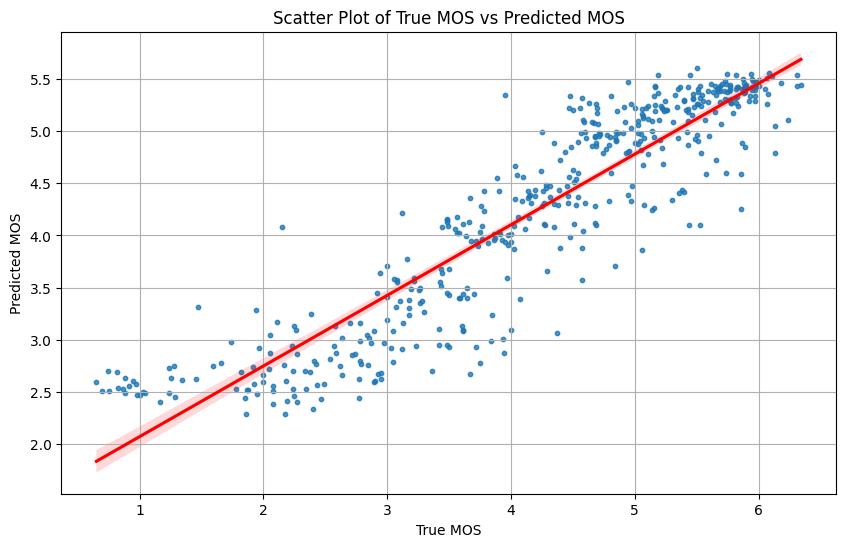

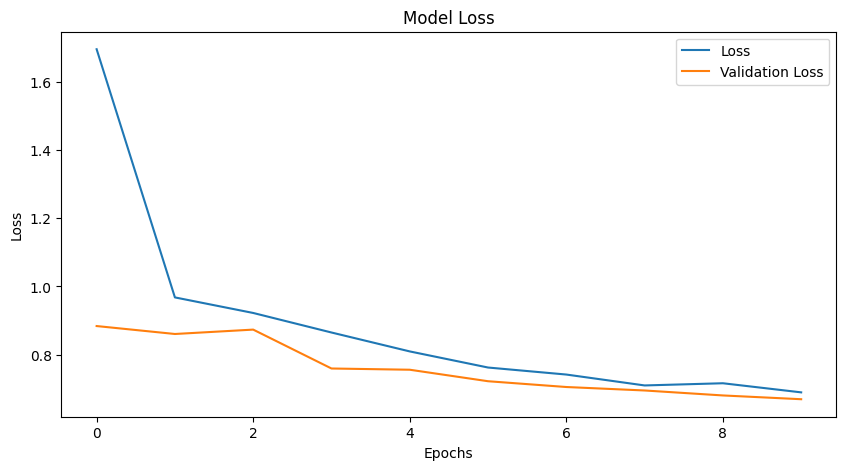

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='MOS', y='Predicted_MOS', data=test_images_mos, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('True MOS')
plt.ylabel('Predicted MOS')
plt.title('Scatter Plot of True MOS vs Predicted MOS')
plt.grid(True)
plt.show()

y_pred = test_predictions
y_true = test_generator.labels
# Training progress (loss minimization)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()